In [11]:
import IPython.display
from ppget.source import DataSource

A_DAY = 60 * 24
DAYS_OF_DATA = 30

# [step] marks the percentage of time advance proportional to the data cursor [size]
source = DataSource("./data/household_power_consumption.txt", size=DAYS_OF_DATA * A_DAY, step=0.33)

# Empty, initialized iterator
source.frame.head()

""


In [12]:
from ppget.model import Model

WINDOW = 25
LEARNING_RATE = 0.00075
MODEL_TYPE = "cnn1d"

online_model = Model(name="online", model_type=MODEL_TYPE, window=WINDOW)
online_model.compile(LEARNING_RATE)
online_model.describe()

Model: "sequential_145"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_145 (Conv1D)         (None, 21, 8)             40        
                                                                 
 dropout_145 (Dropout)       (None, 21, 8)             0         
                                                                 
 flatten_145 (Flatten)       (None, 168)               0         
                                                                 
 dense_290 (Dense)           (None, 8)                 1352      
                                                                 
 dense_291 (Dense)           (None, 1)                 9         
                                                                 
Total params: 1,401
Trainable params: 1,401
Non-trainable params: 0
_________________________________________________________________


In [13]:
# collect R2 results for Online trained models
score_online = []
# collect R2 results for Batch learning
score_batch = []

In [14]:
from sklearn.metrics import r2_score

BATCH_SIZE = 32

# Iterate over 54 windows (roughly 1 and 1/2 years)
for _ in range(0, 54):
    frame = source.__next__()
    # window groups a measurements into a vector of size [sequence_length]
    window = frame.generate_window(train_test_split=0.9, sequence_length=WINDOW)

    # Data is normalized per window [not global!]
    X_train, y_train = window.train_data(True)
    X_test, y_test = window.test_data(True)

    # Always start batch model from scratch
    batch_model = Model(name="batch", model_type=MODEL_TYPE, window=WINDOW)
    batch_model.compile(LEARNING_RATE)

    online_model.fit(
        X_train,
        y_train,
        batch_size=BATCH_SIZE)

    batch_model.fit(
        X_train,
        y_train,
        batch_size=BATCH_SIZE)

    online_predictions = online_model.predict(X_test)
    batch_predictions = batch_model.predict(X_test)

    score_online.append(r2_score(online_predictions, y_test))
    score_batch.append(r2_score(batch_predictions, y_test))
    IPython.display.clear_output()

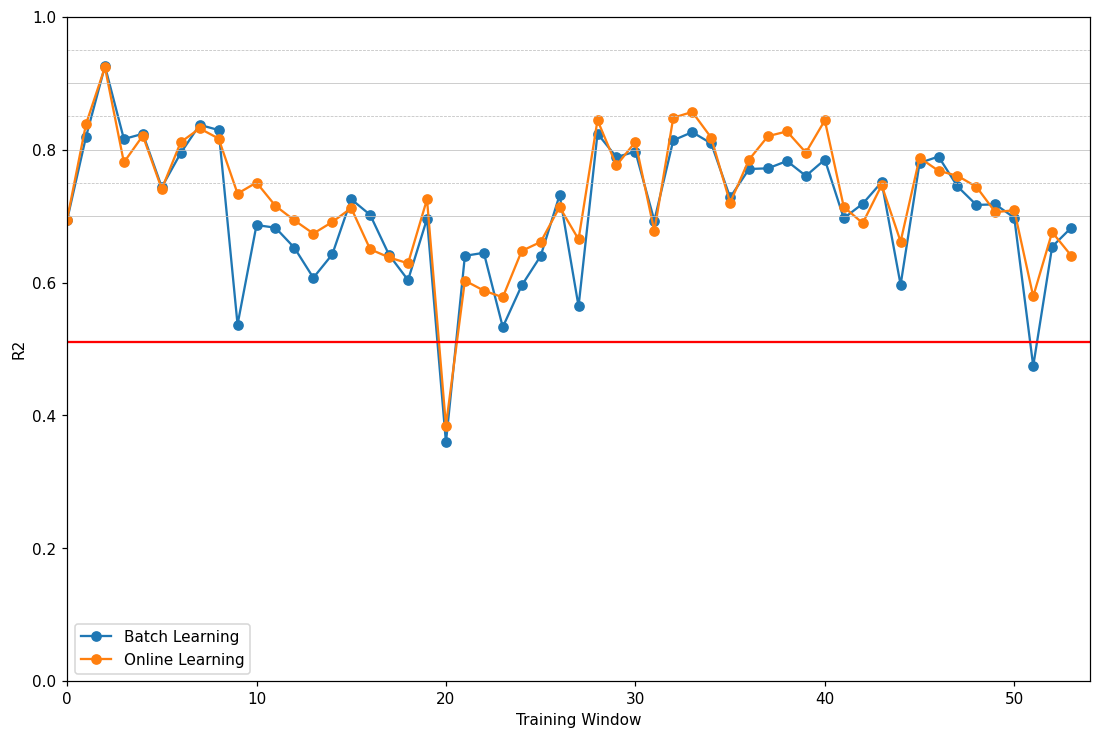

In [17]:
import matplotlib.pyplot as plt

def report_results(batch, online):
    plt.figure(figsize=(12, 8), dpi=110)
    plt.ylim([0, 1])
    plt.xlim([0, 54])
    plt.plot(batch, marker='o', label='Batch Learning')
    plt.plot(online, marker='o', label='Online Learning')
    plt.ylabel("R2")
    plt.xlabel("Training Window")
    plt.legend()
    # plt.axhline(0.5, color='k', linewidth=2)
    plt.axhline(0.51, color='r')
    plt.axhline(0.7, color='silver', linewidth=0.5)
    plt.axhline(0.75, color='silver', linestyle="dashed", linewidth=0.5)
    plt.axhline(0.8, color='silver', linewidth=0.5)
    plt.axhline(0.85, color='silver', linestyle="dashed", linewidth=0.5)
    plt.axhline(0.9, color='silver', linewidth=0.5)
    plt.axhline(0.95, color='silver', linestyle="dashed", linewidth=0.5)
    plt.savefig(f"img/{MODEL_TYPE}_{WINDOW}.png")
    plt.show()

report_results(score_batch, score_online)

In [18]:
import statistics

mean_online = statistics.mean(score_online)
var_online = statistics.stdev(score_online) ** 2
mean_batch = statistics.mean(score_batch)
var_batch = statistics.stdev(score_batch) ** 2

print(f"Online: mean({mean_online:.4f}), var({var_online:.4f}) | Batch: mean({mean_batch:.4f}), var({var_batch:.4f})")

Online: mean(0.7282), var(0.0087) | Batch: mean(0.7100), var(0.0106)
